In [3]:
import numpy as np
from numba import jit, njit
from tqdm import tqdm
from scipy.stats import norm
from typing import *
import pandas as pd
# from numba_stats import norm

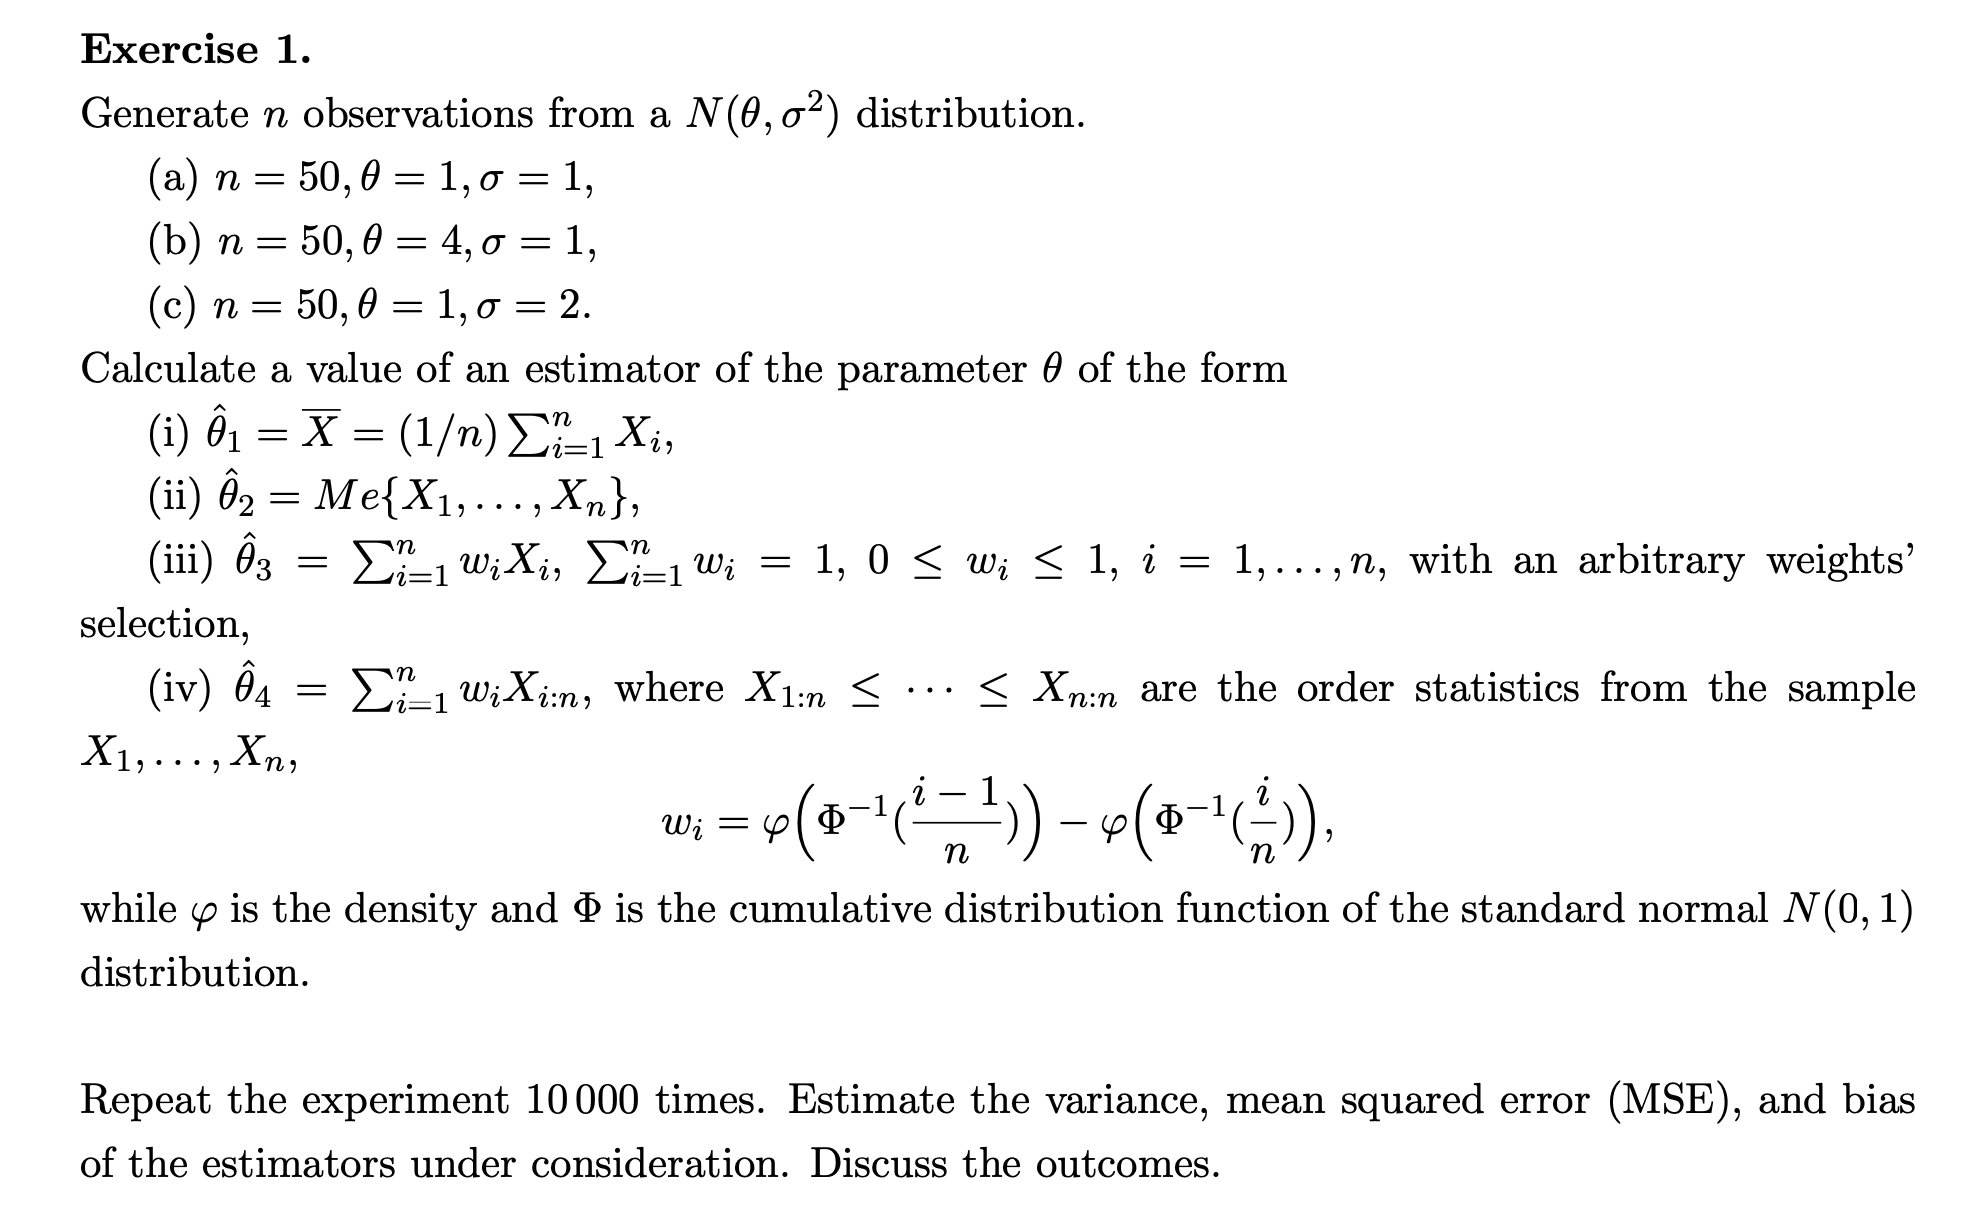

In [24]:
params = [
    (20, 1, 1),
    (20, 4, 1),
    (20, 1, 2),
    
    (50, 1, 1),
    (50, 4, 1),
    (50, 1, 2),
    
    (100, 1, 1),
    (100, 4, 1),
    (100, 1, 2)
]

def theta_1(X) -> float:
    return X.mean()

def theta_2(X) -> float:
    return np.median(X)


def normalize(X):
    return X / X.sum()

W_theta_3 = [
    normalize(np.random.uniform(0, 1, 20)),
    normalize(np.random.uniform(0, 1, 50)),
    normalize(np.random.uniform(0, 1, 100)),
]

def theta_3(X) -> float:
    if len(X) == 20:
        W = W_theta_3[0]
    elif len(X) == 50:
        W = W_theta_3[1]
    elif len(X) == 100:
        W = W_theta_3[2]
    return np.dot(X, W)


W_theta_4 = [
    np.array([norm.pdf(norm.ppf((i - 1) / n)) - norm.pdf(norm.ppf(i / n)) 
    for i in range(1, 21)]),
    
    np.array([norm.pdf(norm.ppf((i - 1) / n)) - norm.pdf(norm.ppf(i / n)) 
    for i in range(1, 51)]),
    
    np.array([norm.pdf(norm.ppf((i - 1) / n)) - norm.pdf(norm.ppf(i / n)) 
    for i in range(1, 101)])
]

def theta_4(X) -> float:
    if len(X) == 20:
        W = W_theta_3[0]
    elif len(X) == 50:
        W = W_theta_3[1]
    elif len(X) == 100:
        W = W_theta_3[2]
    return np.dot(X, W)

In [25]:
def experiment() -> List[List[float]]:
    results = []
    for n, theta, sigma in params:
        X = np.random.normal(theta, sigma, size=n)
        results.append([
            theta_1(X),
            theta_2(X),
            theta_3(X),
            theta_4(X),
        ])
    return results

def mse(X1, X2, N) -> float:
    return np.sum((X1 - X2) ** 2) / N

def bias(estimated, real) -> float:
    return np.mean(estimated - real)

In [26]:
%%time
N = 10000
results = []
for _ in tqdm(range(N)):
    results.append(experiment())

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 3278.12it/s]

CPU times: user 3.02 s, sys: 75.9 ms, total: 3.1 s
Wall time: 3.05 s


In [27]:
for t in range(3):
    print('Task: ', ['a)', 'b)', 'c)'][t])
    theta = params[t][1]
    vars_theta = [
        np.var([r[t][i] for r in results])
        for i in range(4)
    ]

    mse_theta = [
        mse(X1=[r[t][i] for r in results], 
            X2=np.ones(len(results)) * theta,
            N=N
        )
        for i in range(4)
    ]

    bias_theta = [
        bias([r[t][i] for r in results], np.ones(len(results)) * theta)
        for i in range(4)
    ]
    report = pd.DataFrame(
        {
            'var': vars_theta,
            'mse': mse_theta,
            'bias': bias_theta
        }
    )
    print(report.head(4))
    print('\n ==== \n')

Task:  a)
        var       mse      bias
0  0.050044  0.050071  0.005152
1  0.073633  0.073657  0.004907
2  0.071777  0.071809  0.005668
3  0.071777  0.071809  0.005668

 ==== 

Task:  b)
        var       mse      bias
0  0.050141  0.050152 -0.003357
1  0.074086  0.074094 -0.002834
2  0.071073  0.071091 -0.004284
3  0.071073  0.071091 -0.004284

 ==== 

Task:  c)
        var       mse      bias
0  0.195703  0.195810 -0.010374
1  0.287738  0.287858 -0.010947
2  0.285207  0.285337 -0.011390
3  0.285207  0.285337 -0.011390

 ==== 



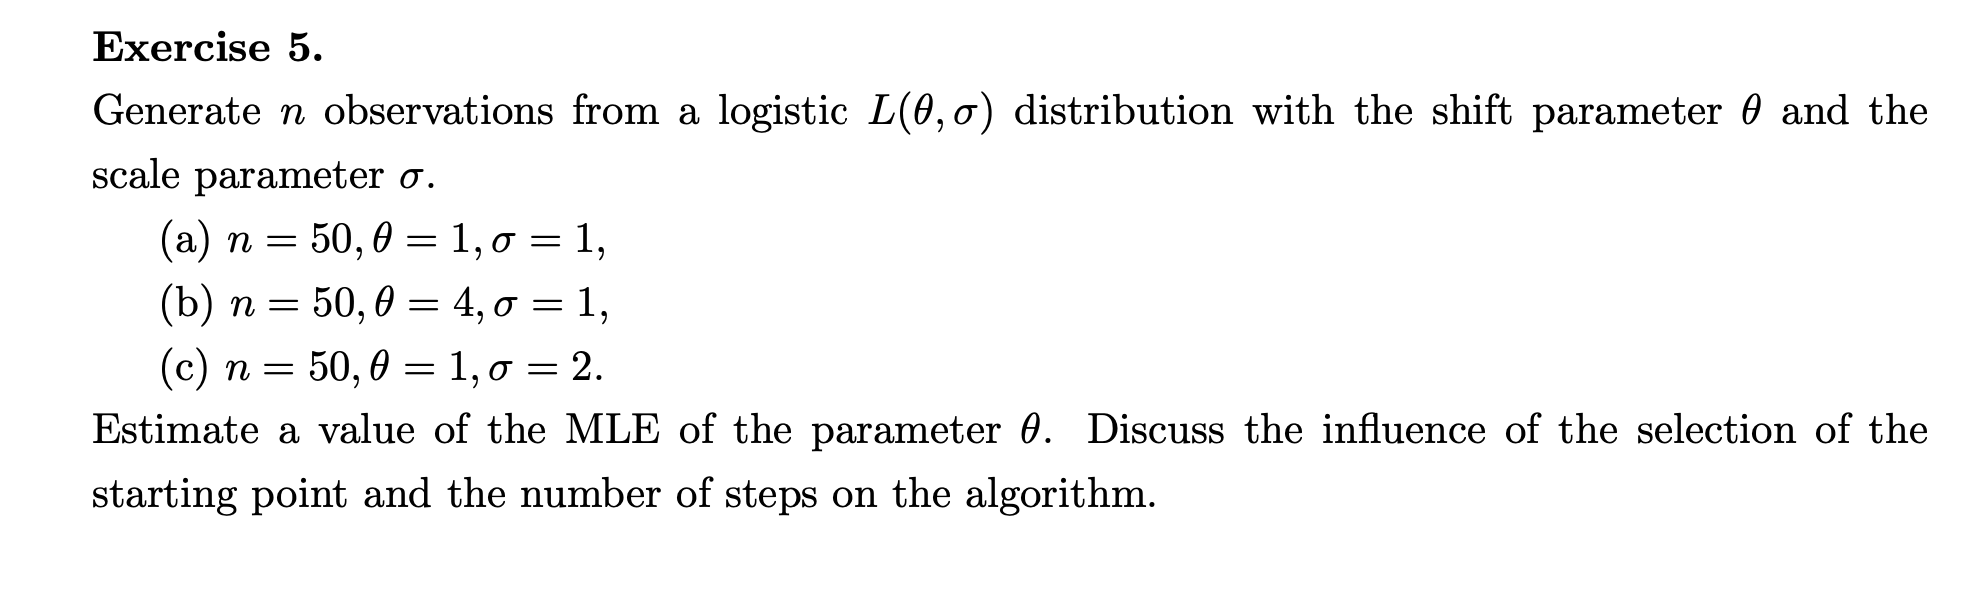
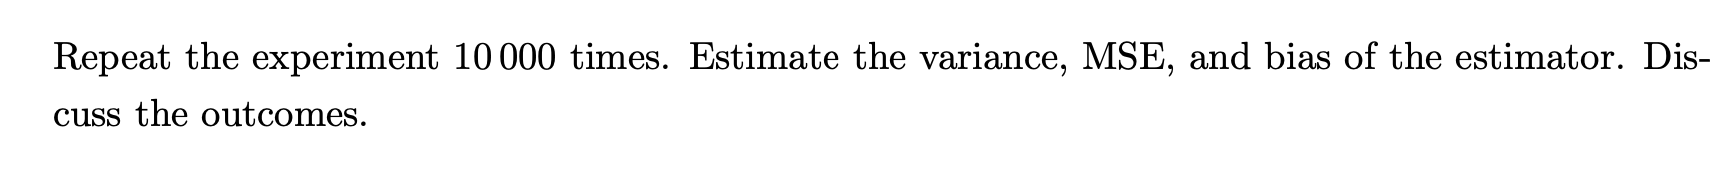

In [28]:
from scipy.stats import logistic
import scipy.optimize as opt

In [29]:
def likelihood(X, theta: float, sigma: float) -> float:
    return np.sum(
        np.log(
            logistic.pdf(X, loc=theta, scale=sigma)
        )
    )

In [30]:
# TODO:
# check median and mean as the starting point
# todo plot the distribution
for n, theta, sigma in params:
    estimators = []
    steps = []
    for i in tqdm(range(10000)):
        X = np.random.logistic(theta, sigma, size=n)
        res = opt.minimize(
            fun=lambda param, data: -likelihood(X=data, theta=param, sigma=sigma),
            x0=np.array([X.mean()]), 
            args=(X,), 
            method='BFGS'
        )
        # print(f'True Theta: {theta}, est: {res.x}, steps: {res.nit}')
        estimators.append(res.x)
        steps.append(res.nit)
    
    print(f'True Theta: {theta}, mean est: {np.mean(estimators)}, mean steps: {np.mean(steps)}')

100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 910.74it/s]


True Theta: 1, mean est: 1.0036223009983727, mean steps: 2.2205


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 923.21it/s]


True Theta: 4, mean est: 3.999586284042783, mean steps: 2.2247


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 897.30it/s]


True Theta: 1, mean est: 1.0049971224703826, mean steps: 3.0675


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 897.53it/s]


True Theta: 1, mean est: 1.00177586441509, mean steps: 2.3257


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 922.14it/s]


True Theta: 4, mean est: 4.002381333838164, mean steps: 2.3235


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1032.62it/s]


True Theta: 1, mean est: 1.0026298640272795, mean steps: 1.8832


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 913.51it/s]


True Theta: 1, mean est: 0.9991585290616191, mean steps: 2.3243


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 907.99it/s]


True Theta: 4, mean est: 3.999372561853935, mean steps: 2.336


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 891.54it/s]

True Theta: 1, mean est: 0.99858460049387, mean steps: 2.0023


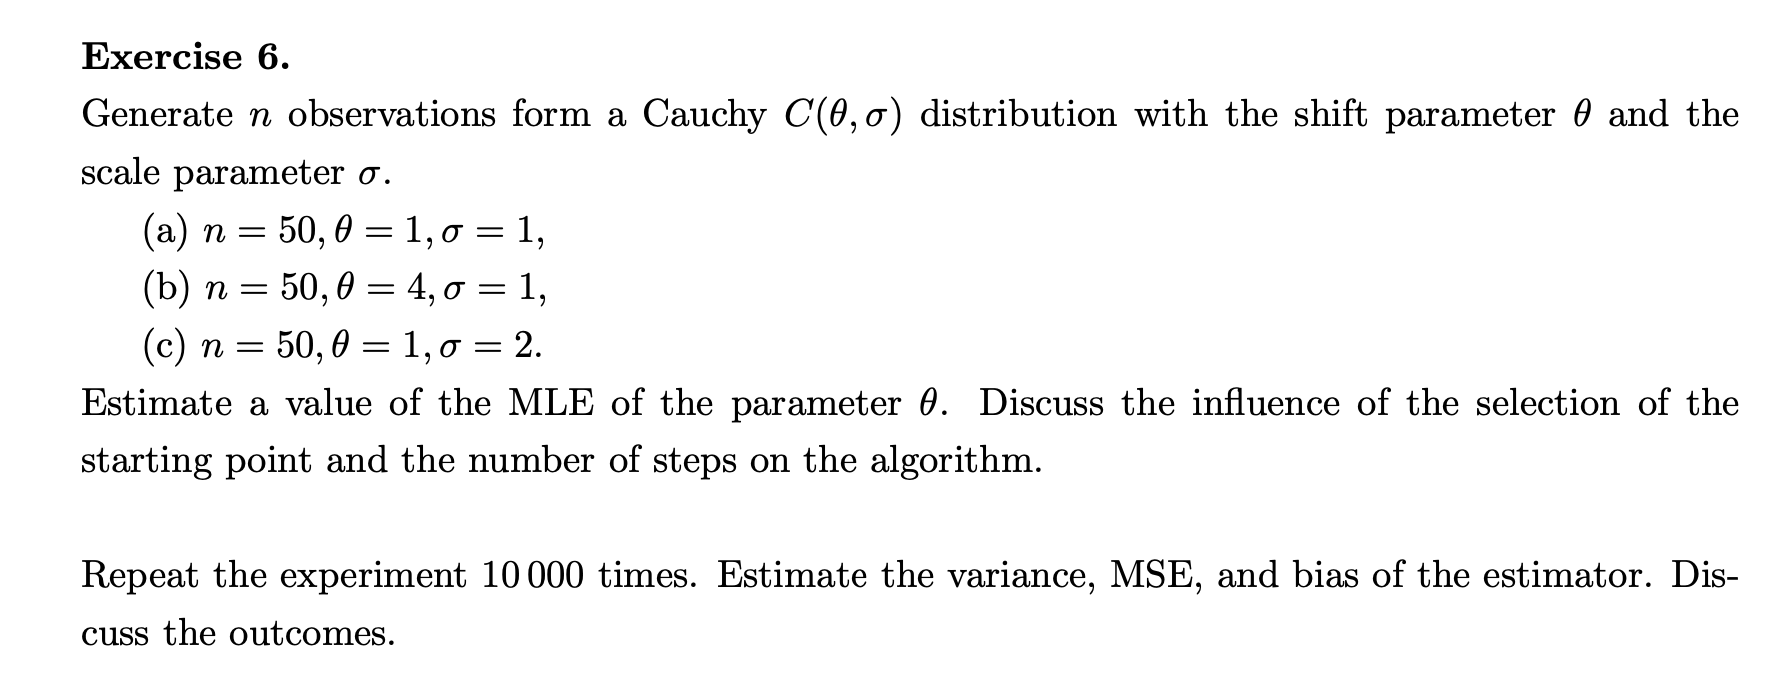

In [31]:
from scipy.stats import cauchy

In [32]:
def likelihood2(X, theta: float, sigma: float) -> float:
    return np.sum(
        np.log(
            cauchy.pdf(X, loc=theta, scale=sigma)
        )
    )

In [33]:
# TODO:
# check median and mean as the starting point
# todo plot the distribution
for n, theta, sigma in params:
    estimators = []
    steps = []
    for i in tqdm(range(10000)):
        X = np.random.logistic(theta, sigma, size=n)
        res = opt.minimize(
            fun=lambda param, data: -likelihood2(X=data, theta=param, sigma=sigma),
            x0=np.array([X.mean()]), 
            args=(X,), 
            method='BFGS'
        )
        # print(f'True Theta: {theta}, est: {res.x}, steps: {res.nit}')
        estimators.append(res.x)
        steps.append(res.nit)
    
    print(f'True Theta: {theta}, mean est: {np.mean(estimators)}, mean steps: {np.mean(steps)}')

100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 714.57it/s]


True Theta: 1, mean est: 1.0008353043568488, mean steps: 3.4802


100%|████████████████████████████████████| 10000/10000 [00:14<00:00, 709.33it/s]


True Theta: 4, mean est: 4.001123359799789, mean steps: 3.5087


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 769.34it/s]


True Theta: 1, mean est: 0.9913582164429565, mean steps: 3.5446


100%|████████████████████████████████████| 10000/10000 [00:14<00:00, 687.02it/s]


True Theta: 1, mean est: 0.9985214366379154, mean steps: 3.2545


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 730.27it/s]


True Theta: 4, mean est: 3.9980862174607035, mean steps: 3.2622


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 793.59it/s]


True Theta: 1, mean est: 0.9977101791032519, mean steps: 3.0472


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 721.14it/s]


True Theta: 1, mean est: 0.9995883114154535, mean steps: 3.135


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 754.53it/s]


True Theta: 4, mean est: 4.000964187738879, mean steps: 3.1469


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 726.23it/s]

True Theta: 1, mean est: 0.9964297835958013, mean steps: 2.9676


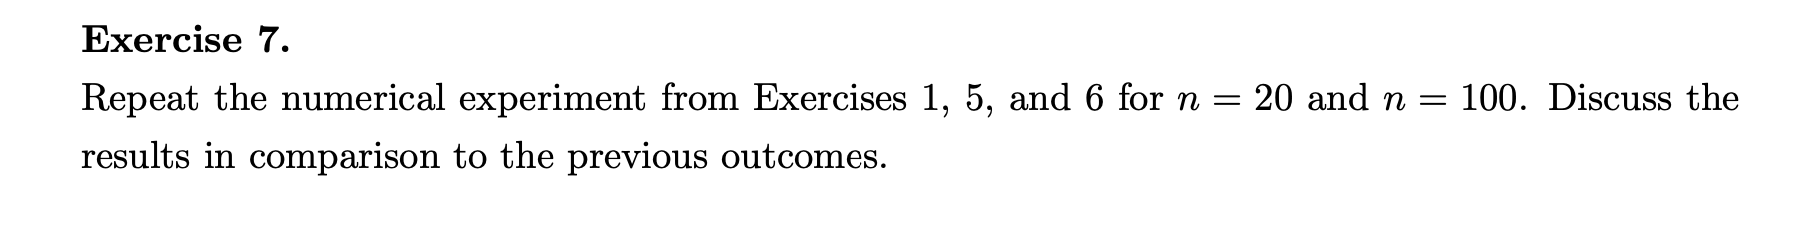

In [ ]:
# don't include charts etc for 20 and 100, just describe what happens